In [40]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.infogram import H2OInfogram
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '..')
from DataModule.Data_Preparation import CoronnaCERTAINDataset
import evaluate
pd.options.mode.chained_assignment = None

In [53]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [41]:
dataset = CoronnaCERTAINDataset(
    library_root='/Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/',
    challenge="two_stage", #option: regression, classification, two_stage
    dataset='CORRONA CERTAIN', 
    process_approach='SC', #option: KVB, SC
    imputation='KNN', #option: SimpleFill, KNN, SoftImpute, BiScaler, NuclearNormMinimization, IterativeImputer, IterativeSVD, None(raw)
    patient_group='bionaive TNF', #option: "all", "bioexp nTNF", "bionaive TNF", "bionaive orencia", "KVB"
    drug_group='all', #option: "all", "actemra", "cimzia", "enbrel", "humira", "orencia", "remicade", "rituxan", "simponi"
    time_points=(0,3), 
    train_test_rate=0.8,
    save_csv=False, 
    random_state=2022)

feature engineering, drop columns due to 70% missing value: Index(['smkyrs', 'numcigs', 'rfstatus_impute', 'ccpstatus_impute',
       'statin_use'],
      dtype='object')
Missing values in train before imputation: 122
Missing values in train after imputation: 0
Missing values in test before imputation: 24
Missing values in test after imputation: 0
save file to: /Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/.csv_temp/Train.csv
save file to: /Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/.csv_temp/Test.csv


In [42]:
train, train_loc = dataset.get_train()
test, test_loc = dataset.get_test()

In [43]:
train.head(10)

,grp,age,gender,final_education,race_grp,ethnicity,weight,BMI,height,newsmoker,...,md_global_assess,pt_global_assess,di,pt_pain,usresultsCRP,usresultsIgA,usresultsIgG,usresultsIgM,DAS28_CRP_0M,DAS28_CRP_3M
0,1.0,54.0,1.0,0.0,7.0,1.0,225.0,31.377703,71.0,3.0,...,50.0,25.0,0.285714,25.0,1.640000,144.0,886.0,113.0,3.189429,1.733190
1,1.0,54.0,0.0,0.0,7.0,1.0,175.0,28.242654,66.0,3.0,...,35.0,17.0,0.250000,25.0,1.190000,207.0,1010.0,56.0,2.935127,2.473876
2,1.0,63.0,0.0,0.0,7.0,1.0,117.0,20.080811,64.0,0.0,...,40.0,10.0,0.000000,5.0,0.400000,190.0,657.0,100.0,2.698947,3.386822
3,1.0,61.0,0.0,0.0,7.0,1.0,240.0,39.933728,65.0,2.0,...,55.0,50.0,0.250000,60.0,1.000000,44.0,948.0,51.0,3.719481,4.444948
4,1.0,64.0,1.0,0.0,7.0,1.0,294.0,41.000198,71.0,2.0,...,55.0,55.0,0.285714,70.0,16.740000,178.0,882.0,87.0,5.146565,2.846272
5,2.0,51.0,0.0,2.0,7.0,1.0,90.0,18.175812,59.0,0.0,...,65.0,20.0,0.250000,65.0,0.250000,155.0,824.0,43.0,4.425214,3.143985
6,3.0,57.0,0.0,0.0,7.0,1.0,161.0,30.417361,61.0,3.0,...,70.0,55.0,1.000000,65.0,8.135924,273.0,714.0,138.0,5.046397,1.521586
7,2.0,62.0,0.0,0.0,7.0,1.0,150.0,26.568405,63.0,2.0,...,50.0,25.0,0.000000,20.0,17.930000,171.0,992.0,95.0,5.278515,1.960279
8,1.0,54.0,1.0,2.0,7.0,1.0,182.0,25.381075,71.0,0.0,...,40.0,10.0,0.142857,5.0,4.700000,267.0,1110.0,109.0,3.604865,1.532090
9,1.0,50.0,0.0,0.0,7.0,1.0,250.0,39.151259,67.0,2.0,...,35.0,27.0,0.500000,20.0,1.330000,402.0,1290.0,89.0,3.809990,3.370891


In [44]:
# Start the H2O cluster (locally)
h2o.init()

# Import a sample binary outcome train/test set into H2O
train_h2o = h2o.upload_file(str(train_loc))
test_h2o = h2o.upload_file(str(test_loc))

# Identify predictors and response
x = train_h2o.columns[:-1]
y = "DAS28_CRP_3M"

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,20 mins 19 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_gaskell_v2vzvz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.876 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [45]:
# Run AutoML for 20 base models
aml = H2OAutoML(max_runtime_secs = 60, seed = 1, project_name = "EHR_RA_SC_reg_5")
aml.train(x=x, y=y, training_frame=train_h2o, leaderboard_frame = test_h2o)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |
11:16:46.508: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, num_tnf, num_nontnf]


11:16:47.30: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, num_tnf, num_nontnf]


11:16:47.289: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, num_tnf, num_nontnf]
11:16:47.945: _train param, Dropping unused columns: [pres_imuran, pres_minocin, num_tnf, num_nontnf]

█
11:16:48.104: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, num_tnf, num_nontnf]


11:16:48.368: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, num_tnf, num_nontnf]

██
11:16:49.690: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, num_tnf, num_nontnf]

█
11:16:50.406: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, num_tnf, num_nontnf]

█
11:16:51.14: _train param, Dropping bad and constant columns: [pres_imuran, p

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_BestOfFamily_5_AutoML_3_20220630_111646,1.15718,1.33906,0.951105,0.264756,1.33906
XGBoost_grid_1_AutoML_3_20220630_111646_model_49,1.16313,1.35287,0.950144,0.261696,1.35287
GBM_grid_1_AutoML_3_20220630_111646_model_2,1.16388,1.35462,0.975758,0.267458,1.35462
DeepLearning_grid_2_AutoML_3_20220630_111646_model_1,1.16626,1.36017,0.96369,0.271738,1.36017
StackedEnsemble_BestOfFamily_4_AutoML_3_20220630_111646,1.16891,1.36634,0.964876,0.265993,1.36634
GBM_2_AutoML_3_20220630_111646,1.16955,1.36784,0.977186,0.26603,1.36784
StackedEnsemble_AllModels_2_AutoML_3_20220630_111646,1.17023,1.36943,0.969418,0.267654,1.36943
StackedEnsemble_AllModels_1_AutoML_3_20220630_111646,1.17093,1.37107,0.970368,0.267867,1.37107
StackedEnsemble_BestOfFamily_3_AutoML_3_20220630_111646,1.17162,1.3727,0.971075,0.267669,1.3727
StackedEnsemble_BestOfFamily_2_AutoML_3_20220630_111646,1.1718,1.37312,0.97137,0.267725,1.37312


In [46]:
lb['model_id']

model_id
StackedEnsemble_BestOfFamily_5_AutoML_3_20220630_111646
XGBoost_grid_1_AutoML_3_20220630_111646_model_49
GBM_grid_1_AutoML_3_20220630_111646_model_2
DeepLearning_grid_2_AutoML_3_20220630_111646_model_1
StackedEnsemble_BestOfFamily_4_AutoML_3_20220630_111646
GBM_2_AutoML_3_20220630_111646
StackedEnsemble_AllModels_2_AutoML_3_20220630_111646
StackedEnsemble_AllModels_1_AutoML_3_20220630_111646
StackedEnsemble_BestOfFamily_3_AutoML_3_20220630_111646
StackedEnsemble_BestOfFamily_2_AutoML_3_20220630_111646


In [49]:
aml_sc = evaluate.AutoBuild(seed=1, project_name="EHR_RA_SC", challenge=dataset.challenge)
test, test_loc = dataset.get_test()
# baseline = test['DAS28_CRP_0M']
# true = test['DAS28_CRP_3M']

for model in lb.as_data_frame()['model_id']:
    m = h2o.get_model(model)
    pred = m.predict(test_h2o).as_data_frame()
    aml_sc.evaluate(model, test, pred)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
drf prediction progress: |████████████████████████

In [19]:
# aml_sc = evaluate.AutoBuild(seed=1, project_name="EHR_RA_SC")
# test, test_loc = dataset.get_test()
# baseline = test['DAS28_CRP_0M']
# true = test['DAS28_CRP_3M']

In [20]:
# pred = pred.as_data_frame()

In [21]:
# aml_sc.evaluate("stackedensemble", test, pred)

In [50]:
regression, classification = aml_sc.leaderboard()

In [54]:
regression

,model,MAE,MSE,RMSE,R2,Pearson_Correlation
0,StackedEnsemble_BestOfFamily_5_AutoML_3_202206...,0.951105,1.339058,1.157177,0.319850,[0.6261883633526714]
1,XGBoost_grid_1_AutoML_3_20220630_111646_model_49,0.950144,1.352870,1.163130,0.312835,[0.6306664711853198]
2,GBM_grid_1_AutoML_3_20220630_111646_model_2,0.975758,1.354618,1.163880,0.311947,[0.6064316584149166]
3,DeepLearning_grid_2_AutoML_3_20220630_111646_m...,0.963690,1.360167,1.166262,0.309128,[0.5572984289390654]
4,StackedEnsemble_BestOfFamily_4_AutoML_3_202206...,0.964876,1.366344,1.168907,0.305991,[0.6253185476717917]
5,GBM_2_AutoML_3_20220630_111646,0.977186,1.367837,1.169546,0.305232,[0.6161378934358644]
6,StackedEnsemble_AllModels_2_AutoML_3_20220630_...,0.969418,1.369430,1.170226,0.304423,[0.6135209215036417]
7,StackedEnsemble_AllModels_1_AutoML_3_20220630_...,0.970368,1.371067,1.170926,0.303592,[0.6129864634611525]
8,StackedEnsemble_BestOfFamily_3_AutoML_3_202206...,0.971075,1.372699,1.171622,0.302763,[0.6160141168470386]
9,StackedEnsemble_BestOfFamily_2_AutoML_3_202206...,0.971370,1.373125,1.171804,0.302547,[0.6160770168723222]


In [57]:
classification.sort_values('Accuracy',ascending=False)

,model,Accuracy,F1-Score
28,DeepLearning_grid_1_AutoML_3_20220630_111646_m...,0.569767,0.560538
70,XGBoost_grid_1_AutoML_3_20220630_111646_model_24,0.558140,0.528212
47,GBM_grid_1_AutoML_3_20220630_111646_model_6,0.523256,0.462018
29,XGBoost_grid_1_AutoML_3_20220630_111646_model_32,0.511628,0.512341
53,DeepLearning_grid_1_AutoML_3_20220630_111646_m...,0.511628,0.486001
65,XGBoost_grid_1_AutoML_3_20220630_111646_model_18,0.500000,0.484705
63,XGBoost_grid_1_AutoML_3_20220630_111646_model_20,0.500000,0.453425
89,XGBoost_grid_1_AutoML_3_20220630_111646_model_14,0.500000,0.479301
68,XGBoost_grid_1_AutoML_3_20220630_111646_model_52,0.488372,0.463202
12,DeepLearning_grid_2_AutoML_3_20220630_111646_m...,0.488372,0.436311


In [58]:
perf = aml.leader.model_performance(test_h2o)
perf


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 1.339058362414162
RMSE: 1.1571768933115465
MAE: 0.9511048613916134
RMSLE: 0.26475620908061465
R^2: 0.31985004275733797
Mean Residual Deviance: 1.339058362414162
Null degrees of freedom: 85
Residual degrees of freedom: 80
Null deviance: 173.54342534255312
Residual deviance: 115.15901916761794
AIC: 283.16655981131515


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_BestOfFamily_5_AutoML_3_20220630_111646,1.15718,1.33906,0.951105,0.264756,1.33906,120,0.583848,StackedEnsemble
XGBoost_grid_1_AutoML_3_20220630_111646_model_49,1.16313,1.35287,0.950144,0.261696,1.35287,83,0.017761,XGBoost
GBM_grid_1_AutoML_3_20220630_111646_model_2,1.16388,1.35462,0.975758,0.267458,1.35462,134,0.008627,GBM
DeepLearning_grid_2_AutoML_3_20220630_111646_model_1,1.16626,1.36017,0.96369,0.271738,1.36017,131,0.017862,DeepLearning
StackedEnsemble_BestOfFamily_4_AutoML_3_20220630_111646,1.16891,1.36634,0.964876,0.265993,1.36634,140,0.068178,StackedEnsemble
GBM_2_AutoML_3_20220630_111646,1.16955,1.36784,0.977186,0.26603,1.36784,198,0.014515,GBM
StackedEnsemble_AllModels_2_AutoML_3_20220630_111646,1.17023,1.36943,0.969418,0.267654,1.36943,210,0.170407,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_3_20220630_111646,1.17093,1.37107,0.970368,0.267867,1.37107,113,0.091983,StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_3_20220630_111646,1.17162,1.3727,0.971075,0.267669,1.3727,120,0.068924,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_3_20220630_111646,1.1718,1.37312,0.97137,0.267725,1.37312,119,0.160265,StackedEnsemble


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

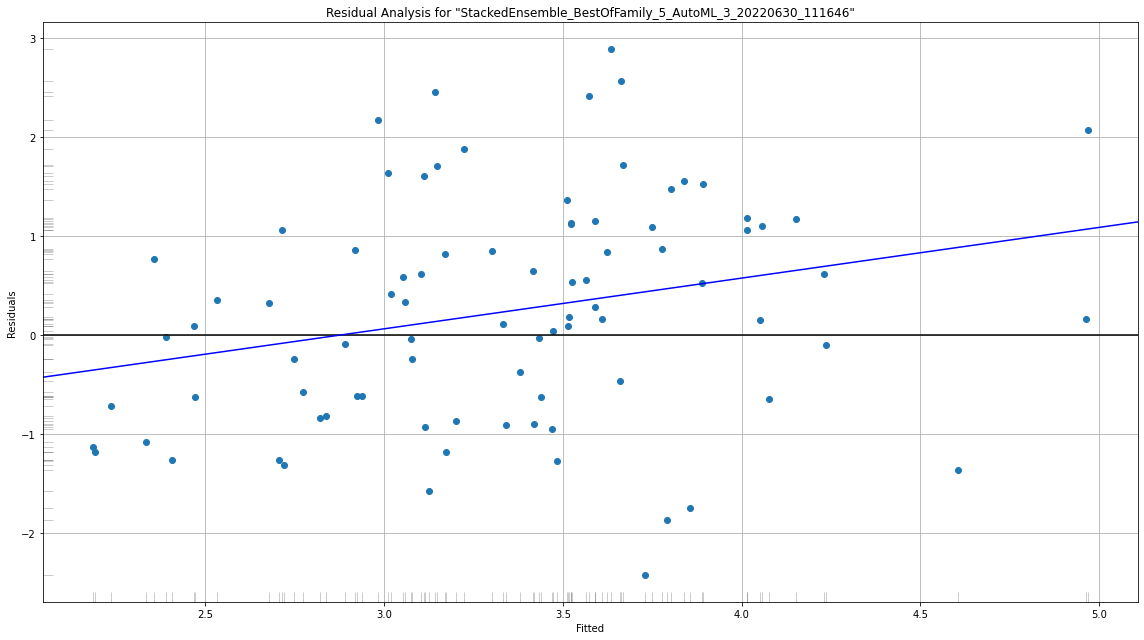

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

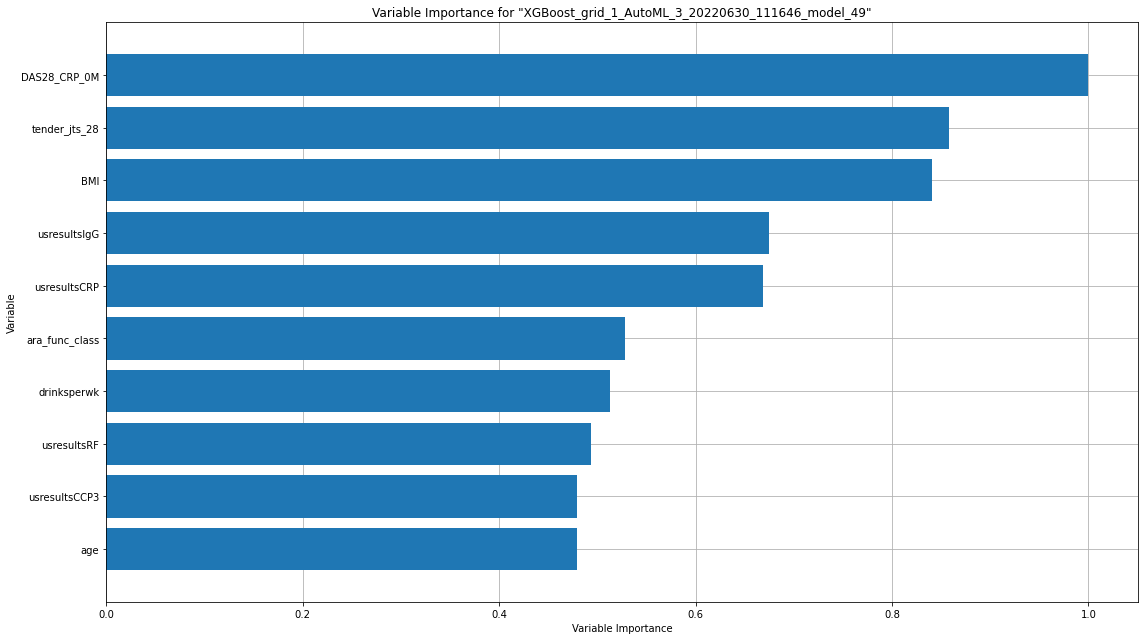

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

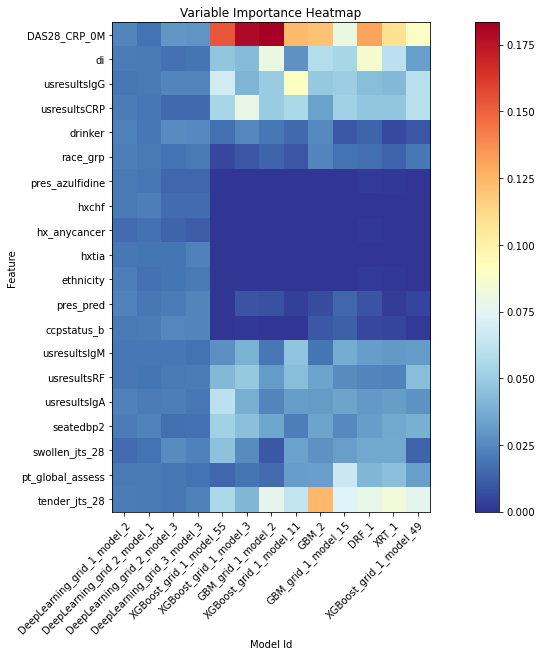

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

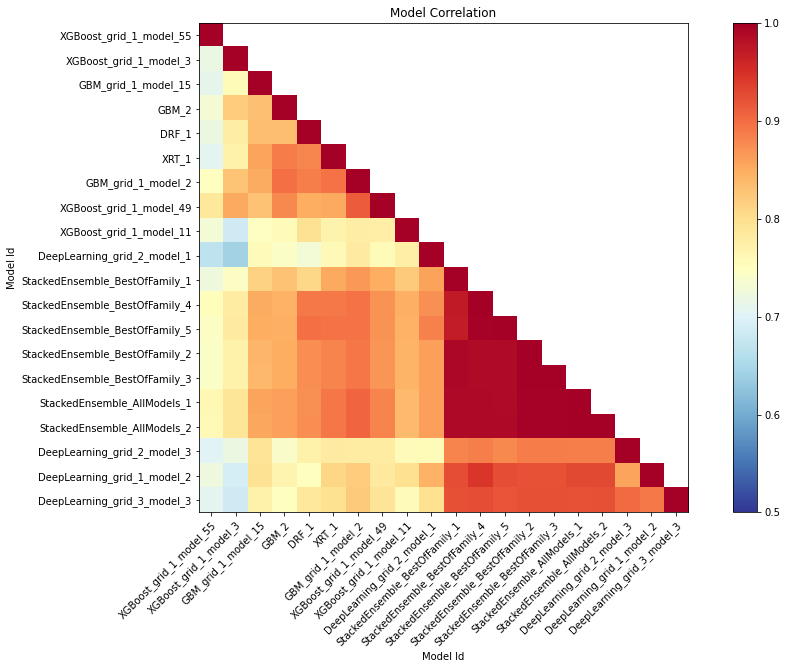

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

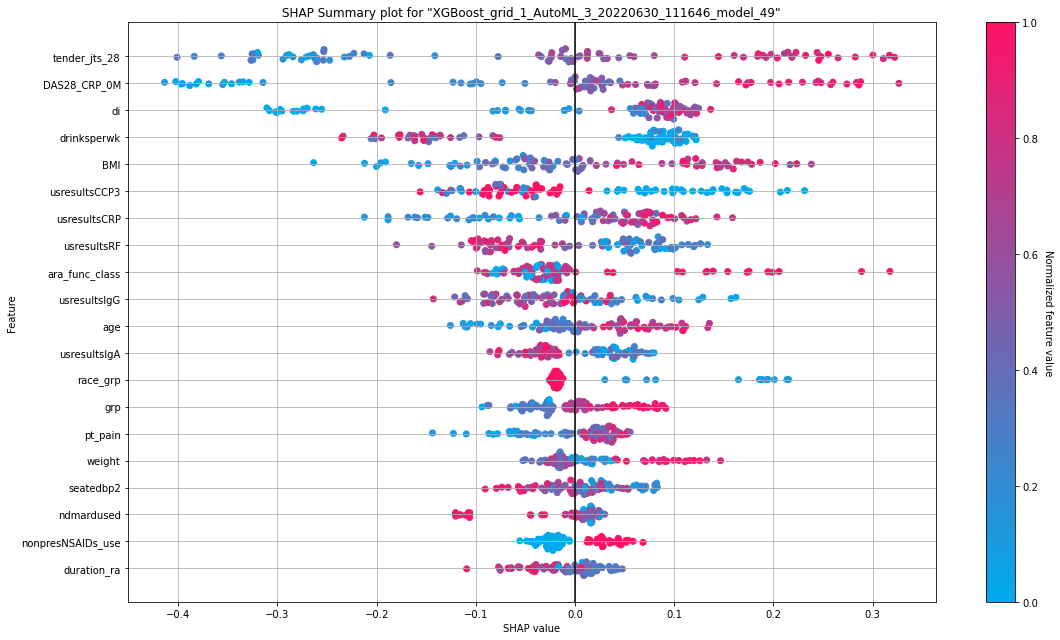

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

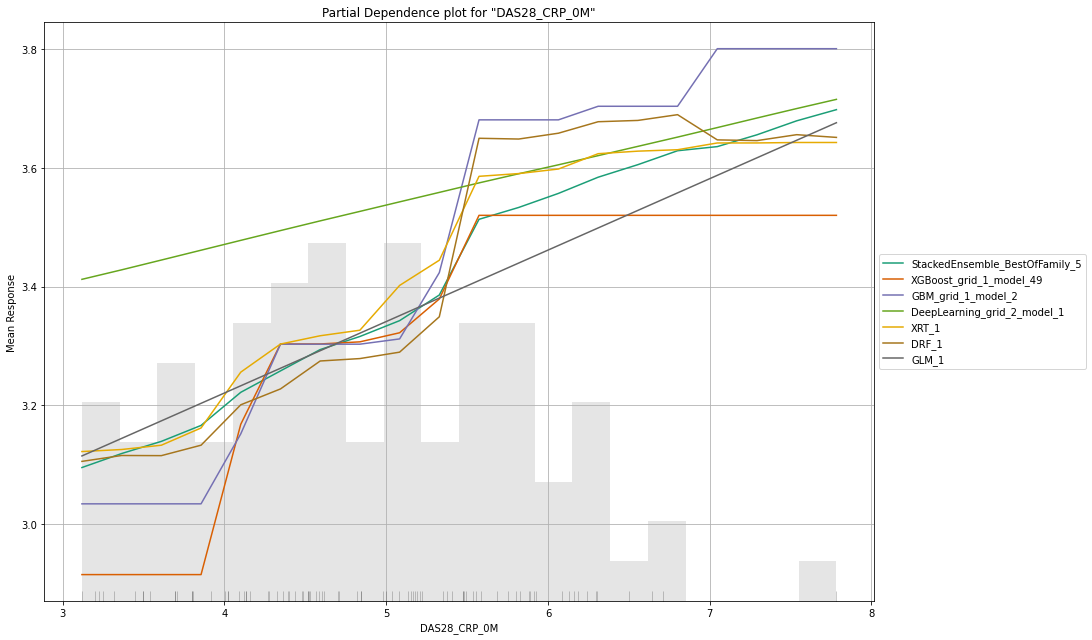

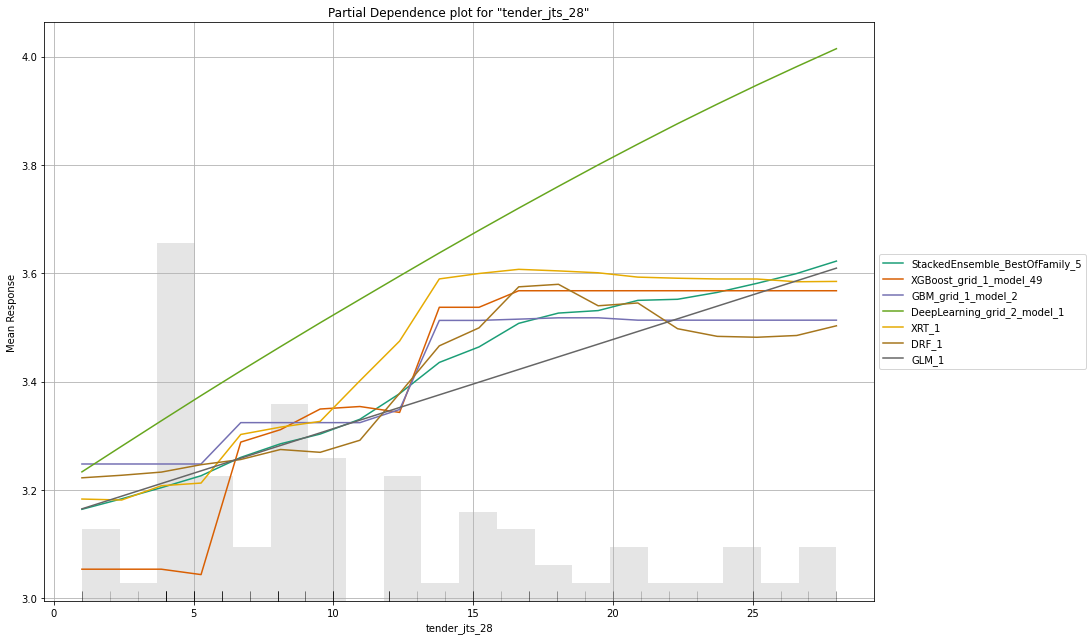

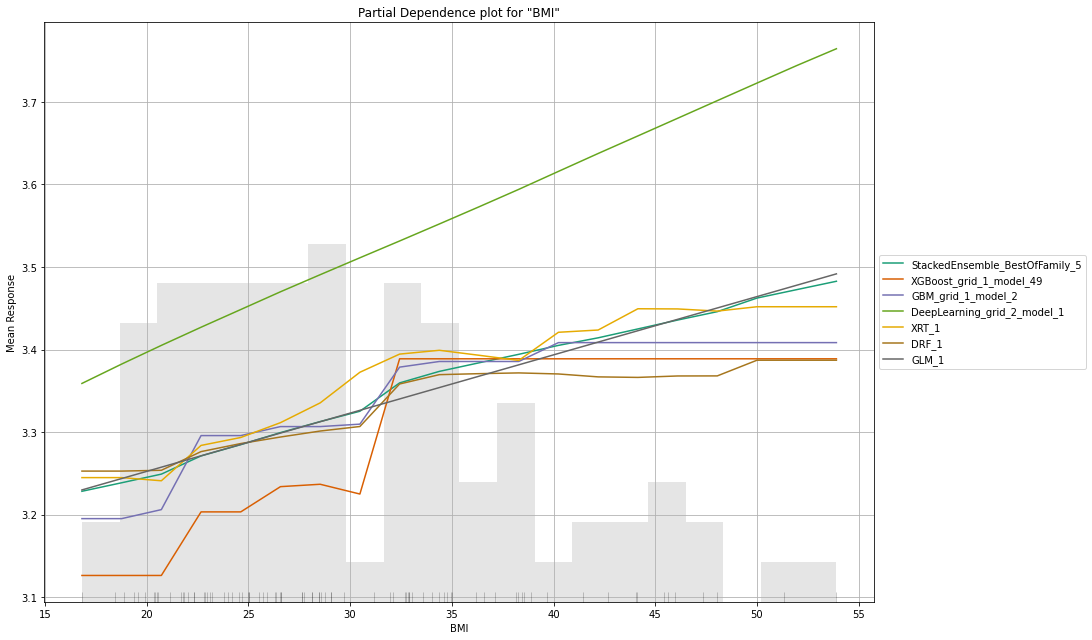

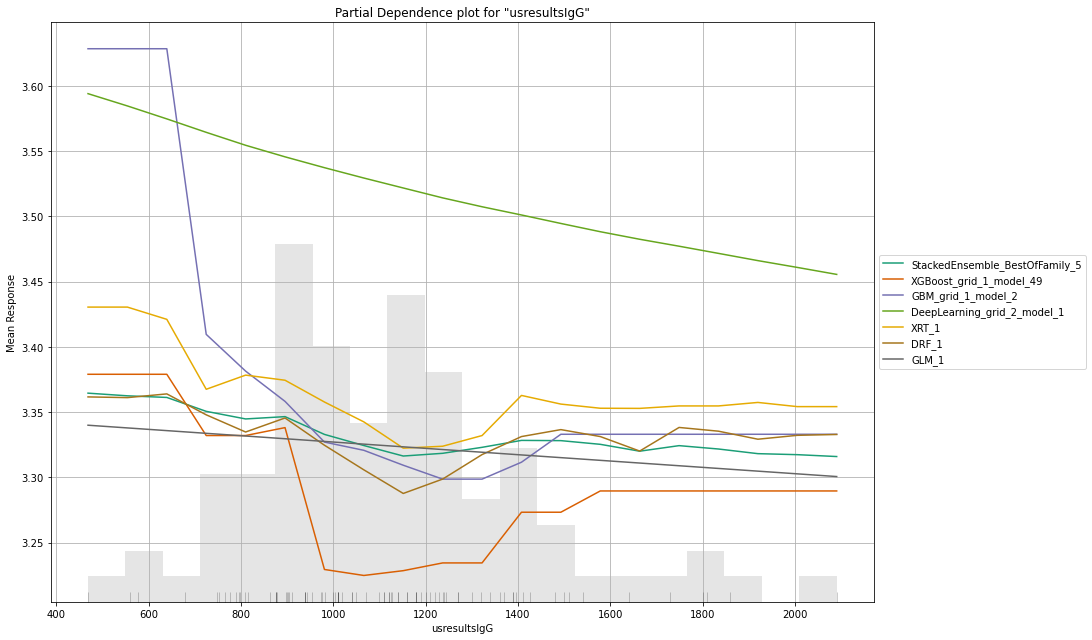

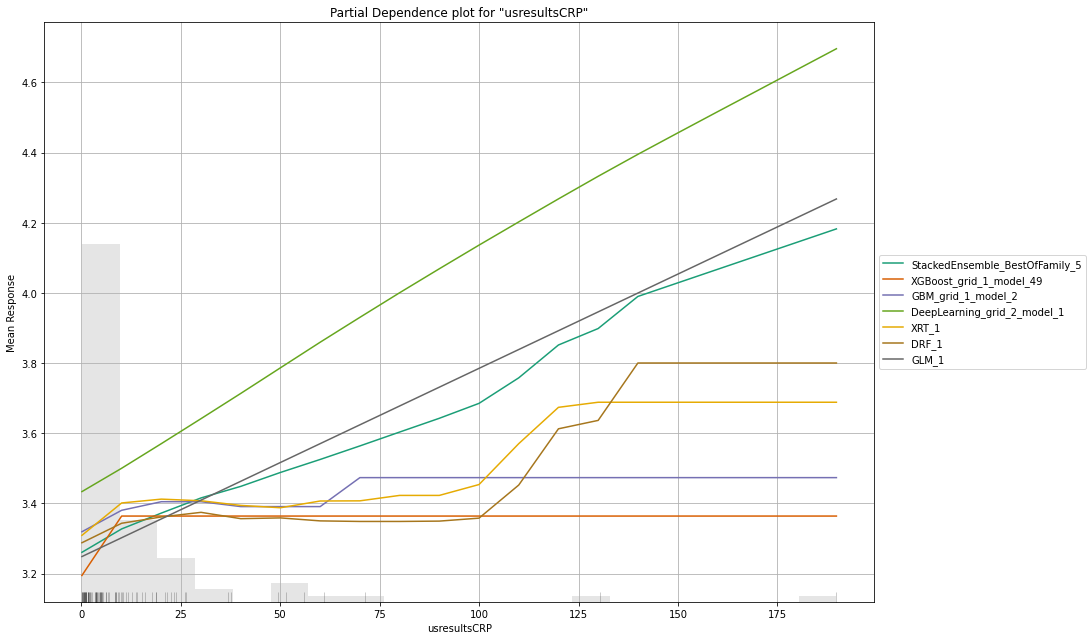

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

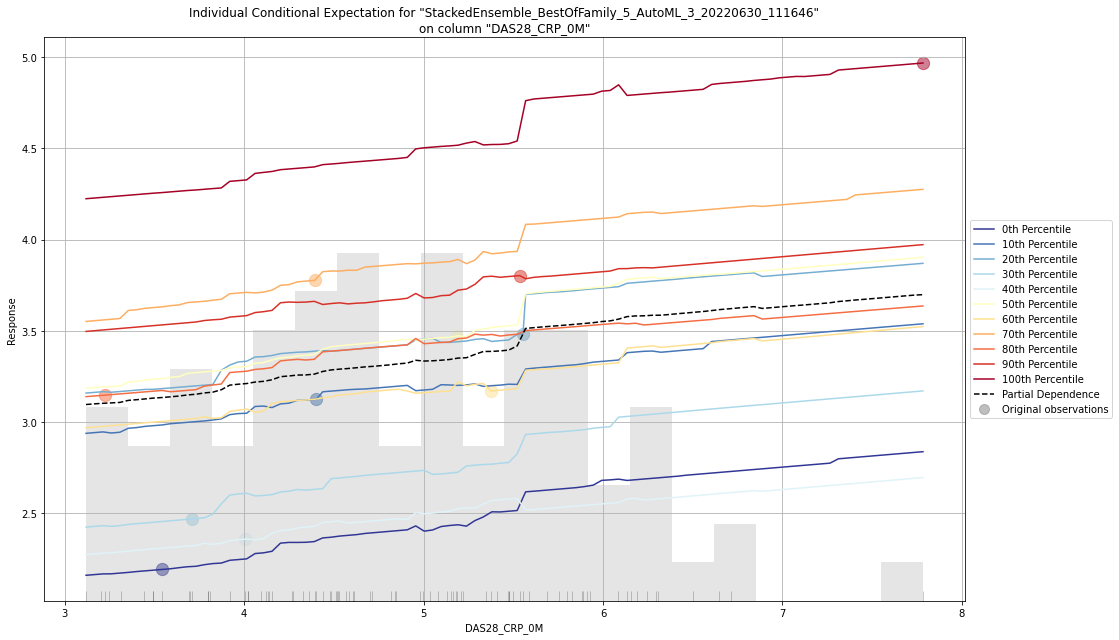

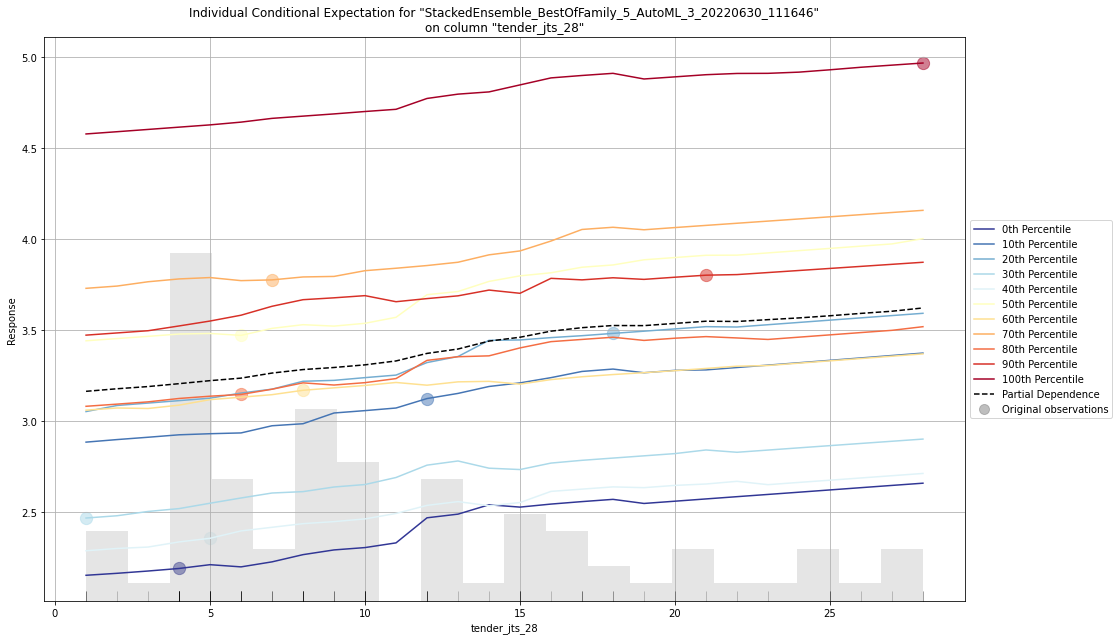

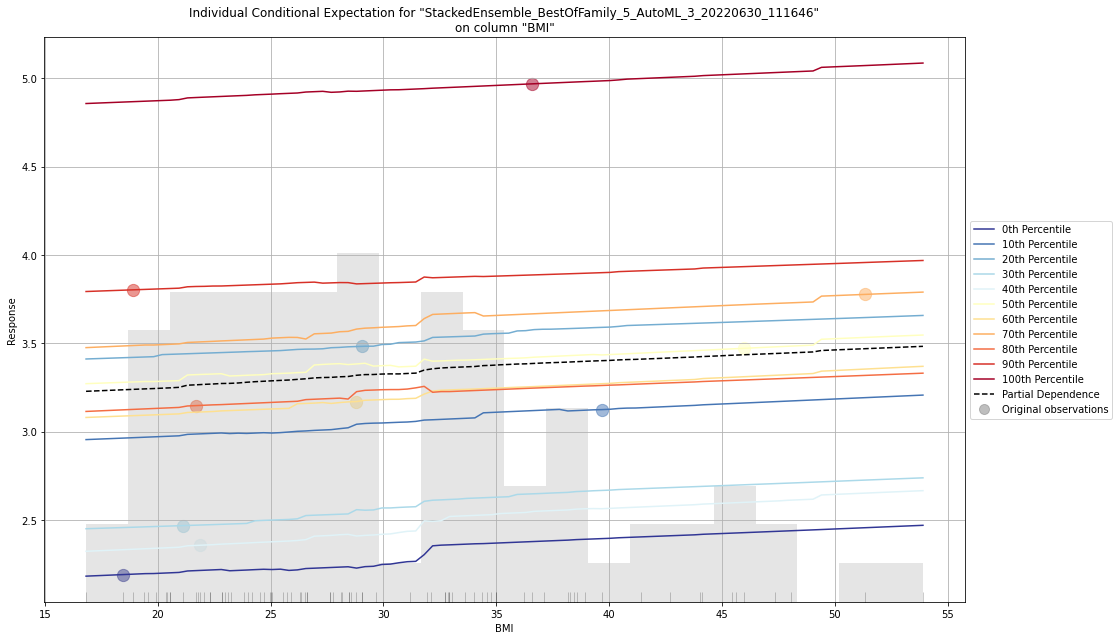

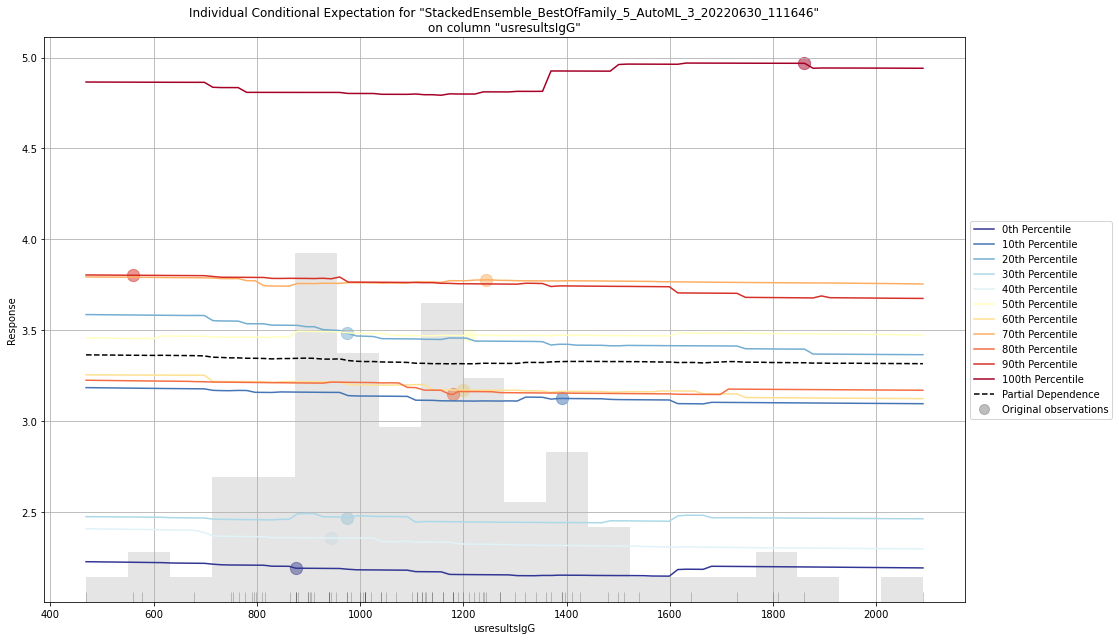

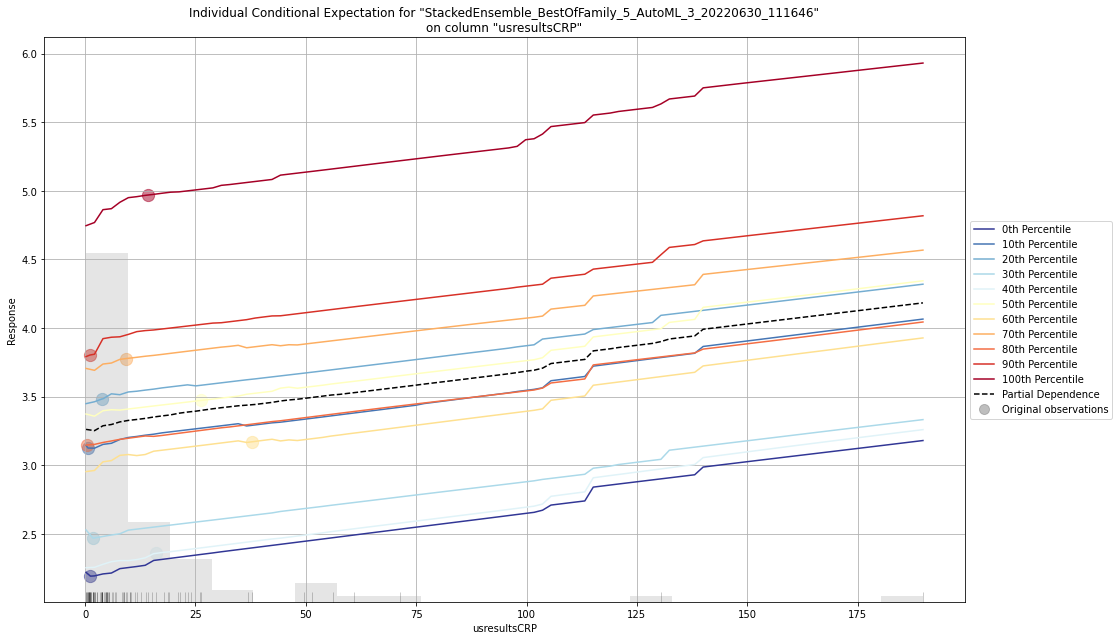

In [60]:
# Explain an AutoML object
exa = aml.explain(test_h2o)